# Info Dataset

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

- Number of Instances: 1797
- Number of Attributes: 64
- Attribute Information: 8x8 image of integer pixels in the range 0..16.
- Missing Attribute Values: None
- Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
- Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is an integer in the range
0..16. This reduces dimensionality and gives invariance to small
distortions.

For info on NIST preprocessing routines, see M. D. Garris, J. L. Blue, G.
T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C.
L. Wilson, NIST Form-Based Handprint Recognition System, NISTIR 5469,
1994.

|details-start|
**References**
|details-split|

- C. Kaynak (1995) Methods of Combining Multiple Classifiers and Their
  Applications to Handwritten Digit Recognition, MSc Thesis, Institute of
  Graduate Studies in Science and Engineering, Bogazici University.
- E. Alpaydin, C. Kaynak (1998) Cascading Classifiers, Kybernetika.
- Ken Tang and Ponnuthurai N. Suganthan and Xi Yao and A. Kai Qin.
  Linear dimensionalityreduction using relevance weighted LDA. School of
  Electrical and Electronic Engineering Nanyang Technological University.
  2005.
- Claudio Gentile. A New Approximate Maximal Margin Classification
  Algorithm. NIPS. 2000.

|details-end|


# Pemodelan

(Insert gambar arsitektur model...) 
- Plan: 2 Layer Perceptron (Hidden Layer: 32 Neuron ReLU, Output Layer: 2 Layer Sigmoid)

In [2]:
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.display import display # Format visual pada tabel.
import seaborn as sns

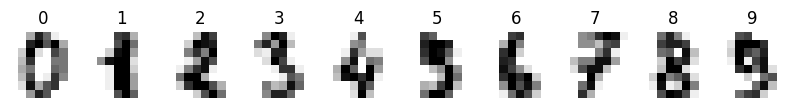

In [7]:
# Loading all the digits dataset (image)
digits = load_digits()
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

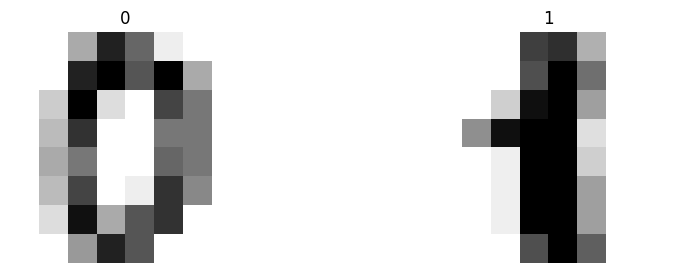

In [141]:
# Loading only digits 0 and 1 (image)
digits = load_digits(n_class=2)
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

In [142]:
# Features as numpy array
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  1., ...,  3.,  0.,  0.],
       ...,
       [ 0.,  0.,  5., ...,  8.,  1.,  0.],
       [ 0.,  0.,  6., ...,  4.,  0.,  0.],
       [ 0.,  0.,  6., ...,  6.,  0.,  0.]])

In [13]:
# Labels as numpy array
digits.target

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,

In [145]:
# Loading the dataset into a dataframe
raw = load_digits(as_frame=True, n_class=2)
df_digit = raw.frame
df_digit.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,1.0,9.0,15.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,10.0,13.0,3.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,14.0,13.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,13.0,16.0,1.0,0.0,1
4,0.0,0.0,3.0,13.0,11.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,12.0,13.0,4.0,0.0,0.0,0


In [146]:
# Class Count
df_digit["target"].value_counts()

target
1    182
0    178
Name: count, dtype: int64

In [ ]:
# on progress

# Pemodelan Dengan Library

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [22]:
# Load the digits dataset with only 2 classes (0 and 1)
digits = load_digits(n_class=2)

# Extract the data and labels
X = digits.data
y = digits.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

In [24]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
X_train.shape

(288, 64)

In [60]:
del model

In [61]:
# Build the model
model = Sequential()
model.add(Input(shape=(64,)))
model.add(Dense(32, activation='relu'))  # Hidden layer with 64 neurons
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [62]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,113 (8.25 KB)

 Trainable params: 2,113 (8.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Compiling & training the model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train,
    y_train, 
    epochs=20
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.5963 - loss: 0.6228
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.7359 - loss: 0.5093
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.8794 - loss: 0.3876
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.9507 - loss: 0.2853
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.9519 - loss: 0.2601
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9549 - loss: 0.2263
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.9638 - loss: 0.1975
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.9683 - loss: 0.1776
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.9621 - loss: 0.1660
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.9765 - loss: 0.1411
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.9848 - loss: 0.1289
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.9807 - lo

In [64]:
# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss: {}".format(loss))
print("Test Accuracy: {}".format(accuracy))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0716 
Test loss: 0.06717018783092499
Test Accuracy: 1.0


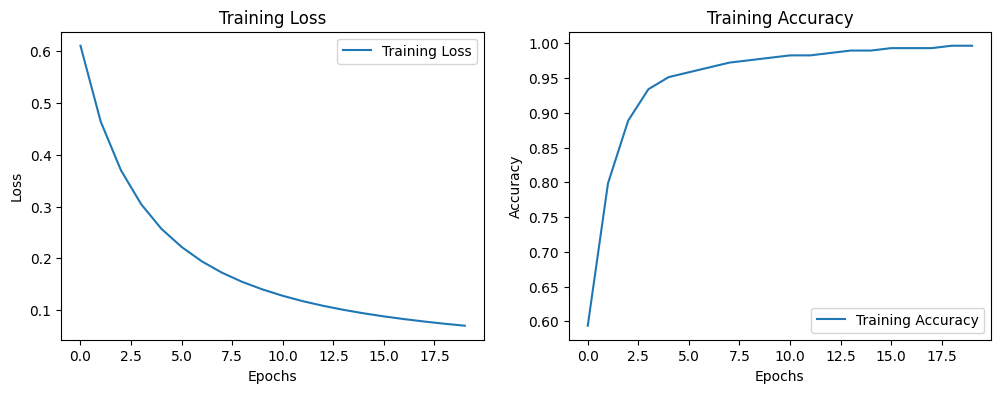

In [65]:
# Learning curve
train_loss = history.history['loss']
train_acc = history.history['accuracy']

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.show()

# Trial & Error

In [81]:
# Load the digits dataset with only 2 classes (0 and 1)
digits = load_digits(n_class=2)

# Extract the data and labels
X = digits.data
y = digits.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [153]:
X_train.shape

(288, 64)

In [48]:
# Initializing parameters (weights & biases of each layer)
def initialize_parameters(input_dim, hidden_dim, output_dim):
    np.random.seed(21)
    W1 = np.random.randn(hidden_dim, input_dim) * 0.01
    b1 = np.zeros((hidden_dim, 1))
    W2 = np.random.randn(output_dim, hidden_dim) * 0.01
    b2 = np.zeros((output_dim, 1))
    return W1, b1, W2, b2

In [152]:
# Test
W1, b1, W2, b2 = initialize_parameters(64, 32, 1)
# print(W1)
# print(W2)
# print(len(W1))
# print(len(W2))
# print(len(W2[0]))
# print(b1)
# print(b2)

[[0.]]


In [66]:
# Activation functions & their derivatives
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)

In [74]:
# Batch forward propagation
# Z1 -> Output of the summation function in the first layer (Vector)
# A1 -> Output of the activation function in the first layer (Vector)
# Z2 -> Output of the summation function in the second/output layer (Vector)
# A2 -> Output of the activation function in the second/output layer (Vector)
# cache -> Store intermediate values during forward pass (so it can be used during back pass)

def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = (Z1, A1, Z2, A2)
    return A2, cache

In [72]:
# Binary cross entropy cost function
def compute_cost(A2, Y):
    m = Y.shape[0]
    cost = -np.sum(Y * np.log(A2) + (1 - Y) * np.log(1 - A2)) / m
    return np.squeeze(cost)

In [76]:
# Backward Propagation
# m -> Number of features in each input (divider)
# dZ2 -> Gradient of the Loss w.r.t Z2
# dW2 -> Gradient of the Loss w.r.t W2
# db2 -> Gradient of the Loss w.r.t b2
# dZ1 -> Gradient of the Loss w.r.t Z1
# dW1 -> Gradient of the Loss w.r.t W1
# db1 -> Gradient of the Loss w.r.t b1

def backward_propagation(X, Y, cache, W1, W2):
    m = X.shape[1]
    Z1, A1, Z2, A2 = cache

    # Gradient of the output layer
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    # Gradient of the hidden layer 
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    return dW1, db1, dW2, db2

In [77]:
# Updating parameters (Optimization)
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1 
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

In [106]:
# Model Fit Function
def model(X_train, Y_train, input_dim, hidden_dim, output_dim, num_iterations=100, learning_rate=0.01):
    W1, b1, W2, b2 = initialize_parameters(input_dim, hidden_dim, output_dim)
    
    for i in range(num_iterations):
        A2, cache = forward_propagation(X_train.T, W1, b1, W2, b2)
        cost = compute_cost(A2, Y_train.T)
        dW1, db1, dW2, db2 = backward_propagation(X_train.T, Y_train.T, cache, W1, W2)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        # print(f"Iteration {i}, Cost: {cost}")
        
        if i % 100 == 0:
            print(f"Iteration {i}, Cost: {cost}")
    
    return W1, b1, W2, b2

In [136]:
def predict(X, W1, b1, W2, b2):
    A2, _ = forward_propagation(X.T, W1, b1, W2, b2)
    print("Predicted probabilities:", A2)
    print("")
    predictions = (A2 > 0.5).astype(int)
    print("Binary predictions:", predictions)
    print("")
    return predictions

In [160]:
# Training the model
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1
Y_train = y_train.reshape(-1, 1)
Y_test = y_test.reshape(-1, 1)

W1, b1, W2, b2 = model(X_train, Y_train, input_dim, hidden_dim, output_dim, num_iterations=20, learning_rate=0.01)

Iteration 0, Cost: 0.6934560073542424


In [161]:
# Make predictions on the test set
predictions = predict(X_test, W1, b1, W2, b2)

# Calculate accuracy
accuracy = np.mean(predictions == Y_test.T)
print("Target: {}\n".format(Y_test.T))
print(f"Test Accuracy: {accuracy * 100}%")

Predicted probabilities: [[0.50136719 0.50024905 0.50038183 0.50110261 0.49965146 0.50034508
  0.50067155 0.50136911 0.50016712 0.50062328 0.50024947 0.49985081
  0.50173458 0.5010209  0.50015485 0.5004723  0.50017527 0.50005502
  0.50003432 0.49970541 0.50010578 0.49978792 0.50009424 0.50027929
  0.50181529 0.50015643 0.49971232 0.50013102 0.5001683  0.50166377
  0.50018871 0.50198345 0.50126085 0.50144272 0.5012042  0.50135502
  0.50124241 0.49936653 0.49944534 0.4998659  0.50052484 0.49982678
  0.5009001  0.50052042 0.50173994 0.50130891 0.50285992 0.50173281
  0.50222803 0.50112529 0.50095015 0.5004049  0.49991894 0.4999305
  0.50025644 0.50017437 0.50178016 0.4994905  0.49993856 0.50115633
  0.4995658  0.50097302 0.50020414 0.4996493  0.50183637 0.50007775
  0.50014832 0.50054598 0.50035076 0.50065537 0.49984249 0.50027021]]

Binary predictions: [[1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
  1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1